<a href="https://www.kaggle.com/code/siddp6/air-passengers-monthly-prediction-using-arima?scriptVersionId=140384750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict


from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load and explore data

In [3]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')

In [4]:
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


<Axes: >

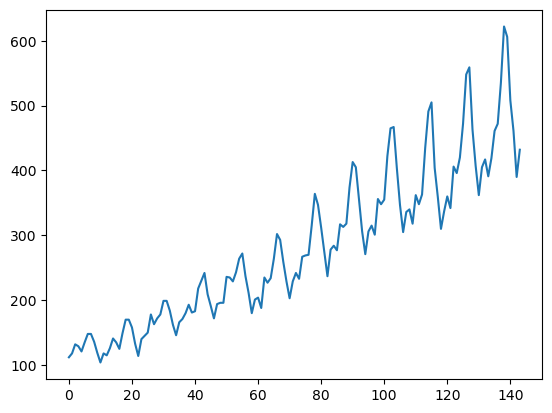

In [5]:
data['#Passengers'].plot()

# Understanding ARIMA Parameters
The key points to understand here are p, d, and q. Let's delve into their meanings: 👓

- p: Autoregressive Order. This is the number of past observations considered for making future predictions. ⌛

- q: Moving Average Order. It accounts for a specific number of previous residuals when making future predictions. 📊

- d: Integration Order. It determines the number of differences needed to make the time series stationary (T(q) - T(q-1)).

# Finding d

- ARIMA models work with __stationary__ data, where the mean and standard deviation remain relatively constant over time.

- We will use __Augmented Dickey-Fuller (ADF) test__, a common statistical test used to determine whether a given time series is stationary or not

- If data fail the test (p > .05), then we will perform ```difference``` operation on data.

- We will keep on doing differencing till our data pass ADF.

- Number of time we perform the differencing, will be the value of __Integration Order (d)__

In [6]:
d = 0
p_value = adfuller(data['#Passengers'])[1]
diff_data = data['#Passengers']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1

    
print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 2.7328918500142026e-29	 Number of differencing needed: 2


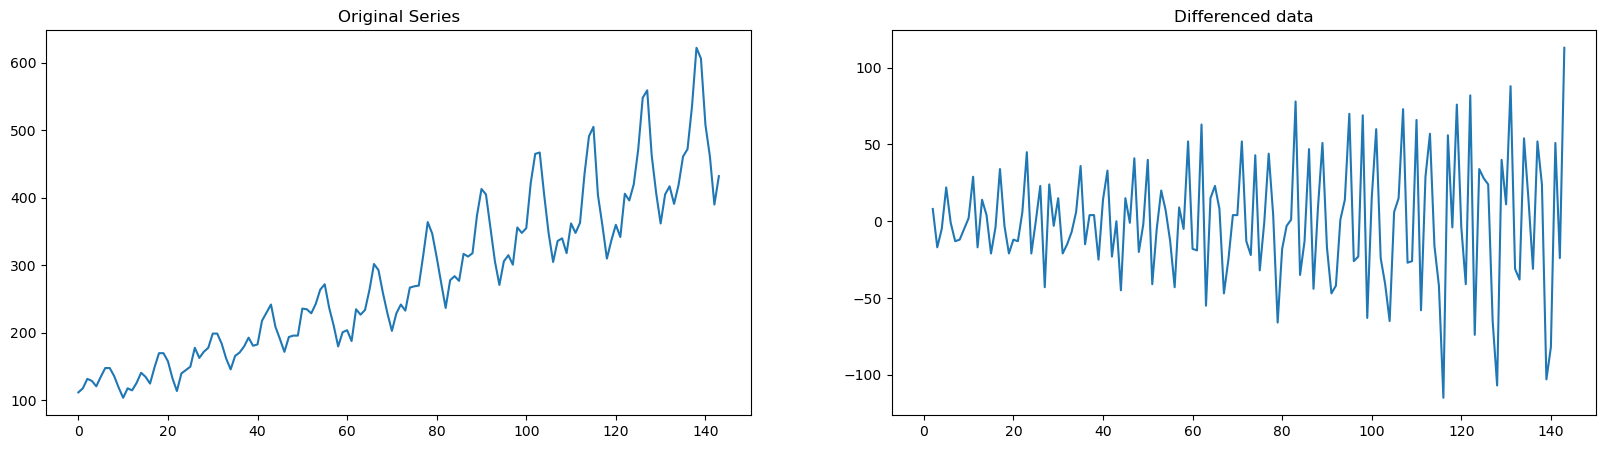

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
axes[0].plot(data['#Passengers']); axes[0].set_title('Original Series')
axes[1].plot(diff_data); axes[1].set_title('Differenced data')
plt.show()

> We can see that data look stationary now, as values are euqally distributed around zero. So we can proceed ahead.

> __d = 2__

# Finding p

- We will use __Partial Autocorrelation (PACF) plot.__

- __Partial Autocorrelation__, is the correlation between current value and a particular value in past, ignoring all values in between.

- We can use PACF graph to find the last significat lag that is above the threshold area.

- Number of lags between that last and first lag is the, value of __AR (p)__.

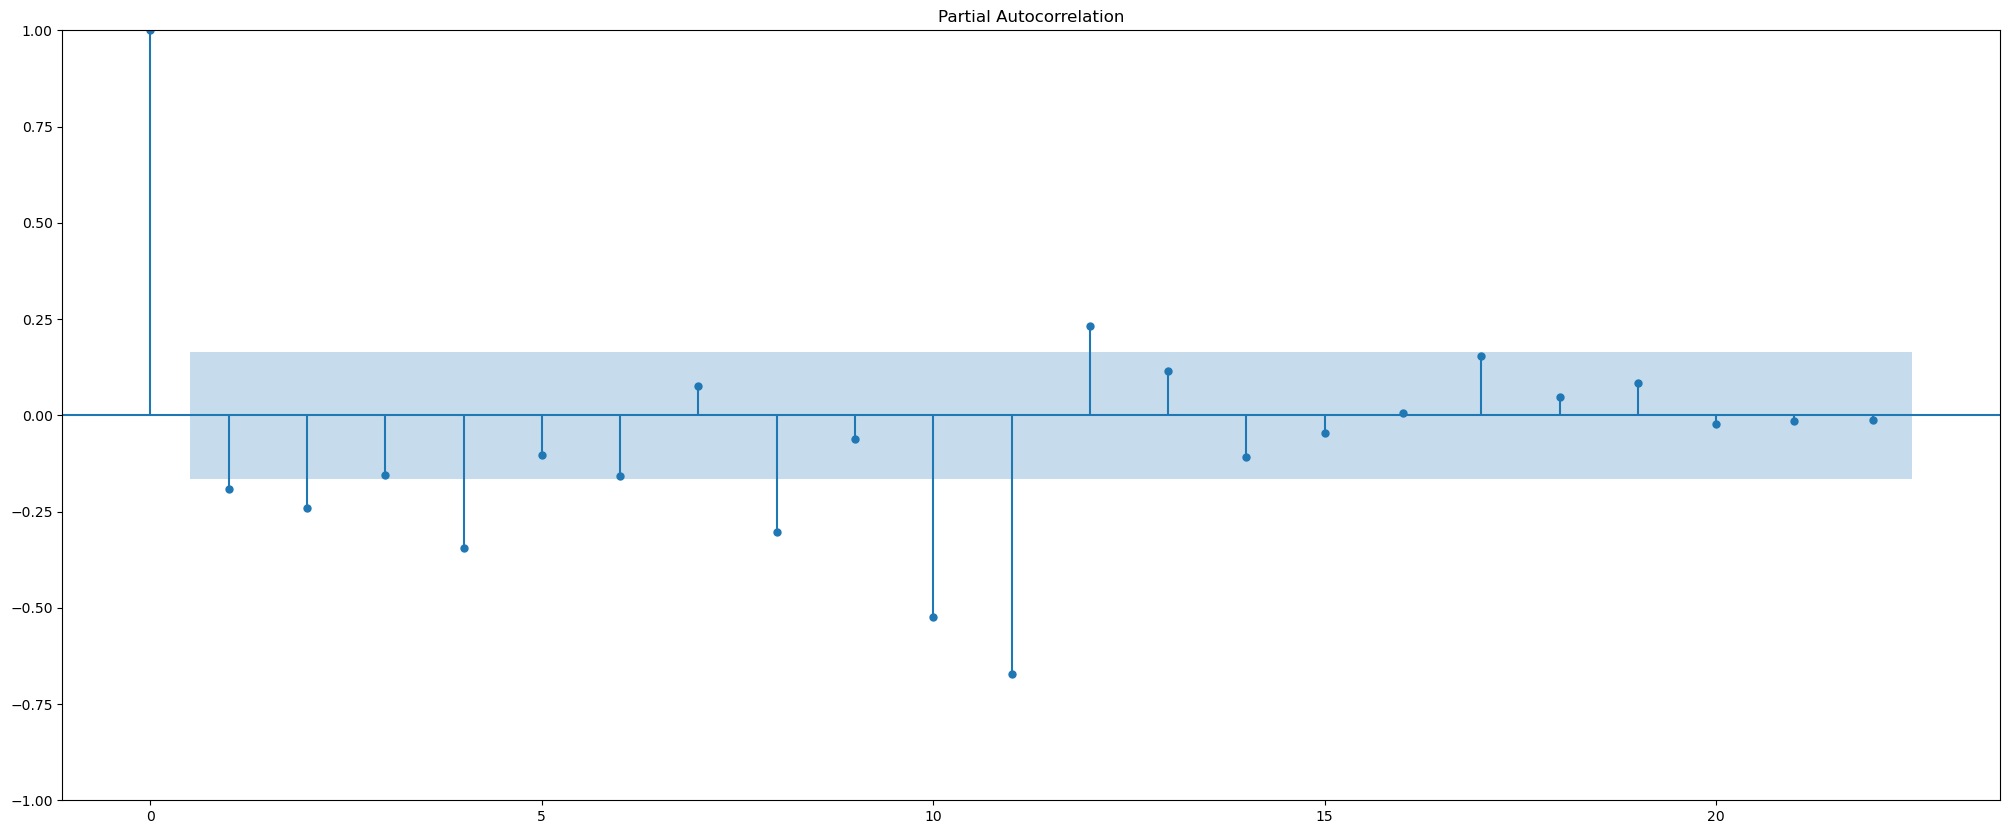

In [8]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(diff_data.dropna(), ax=ax)
plt.show()

> Last significat lag is 11, so value of __p = 11__

# Finding q

- We will use __Autocorrelation (PACF) plot.__

- __Autocorrelation__, is tells the number MA that should be removed so that there is no autocorrelation in the stationarized series.

- Number of lags outside the threshold area is the, value of __MR (q)__.

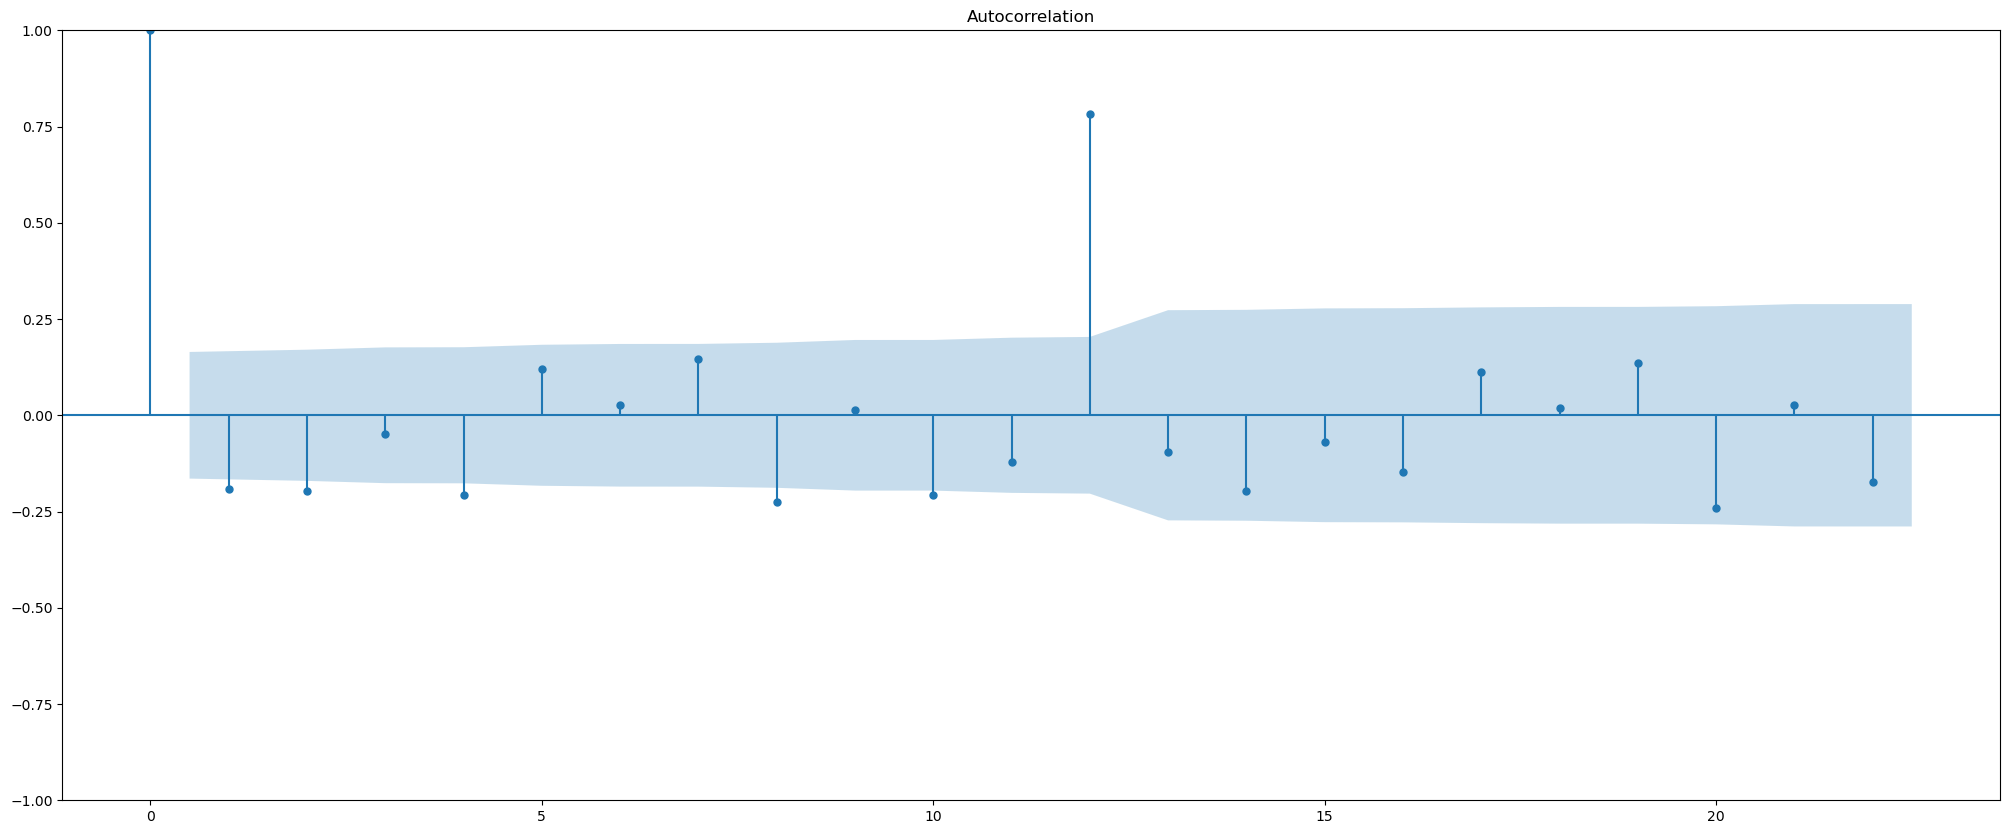

In [9]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(diff_data.dropna(), ax=ax)
plt.show()

> There is only one outside the area significantly, so value of __q = 1__

# Model

In [10]:
model = ARIMA(data['#Passengers'].values, order=(11,2,1))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:                ARIMA(11, 2, 1)   Log Likelihood                -557.654
Date:                Sat, 19 Aug 2023   AIC                           1141.307
Time:                        14:04:10   BIC                           1179.733
Sample:                             0   HQIC                          1156.922
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8716      0.069    -12.659      0.000      -1.007      -0.737
ar.L2         -0.9382      0.044    -21.325      0.000      -1.024      -0.852
ar.L3         -0.9009      0.070    -12.909      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


> We can see that column P>|z| is 0 for all coefficient, that is good thing as p should be smaller than 0.05.

> Also all coefficient are very significant

> Concluding that we do not need to remove(reduce) and parameter value.

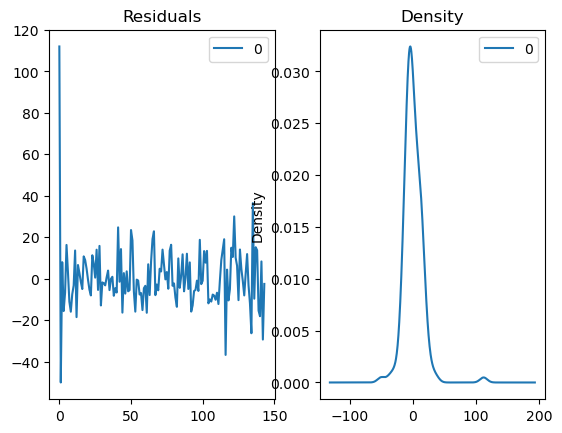

In [11]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

> Residual graph is very favourable, as it is distrubited near zero. Concluding that the mean and variance is constant.

# Forecast

0
143


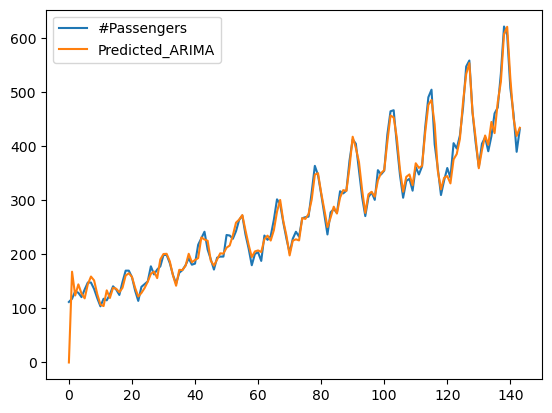

<Figure size 1000x600 with 0 Axes>

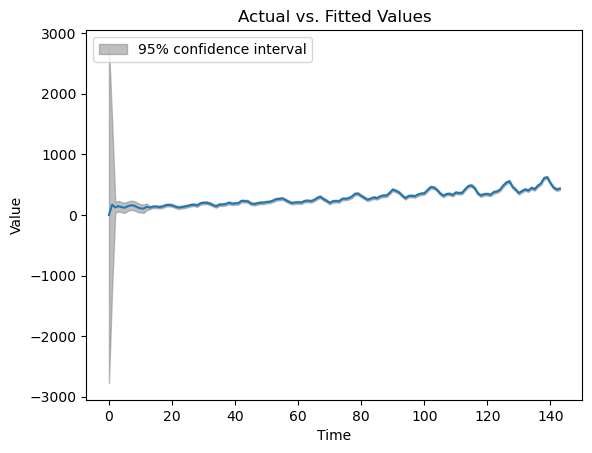

In [12]:
##prediction
pred_start_date=data['Month'].index[0]
pred_end_date=data['Month'].index[-1]
print(pred_start_date)
print(pred_end_date)

pred=model_fit.predict(start=pred_start_date,end=pred_end_date)
data['Predicted_ARIMA']=pred

data[['#Passengers','Predicted_ARIMA']].plot()

# Plot actual vs. fitted values
plt.figure(figsize=(10, 6))
plot_predict(model_fit, dynamic=False)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Fitted Values')
plt.legend(loc='upper left')
plt.show()

> Most values are inside confidence interval, so we are good to forecast the data now

<Axes: >

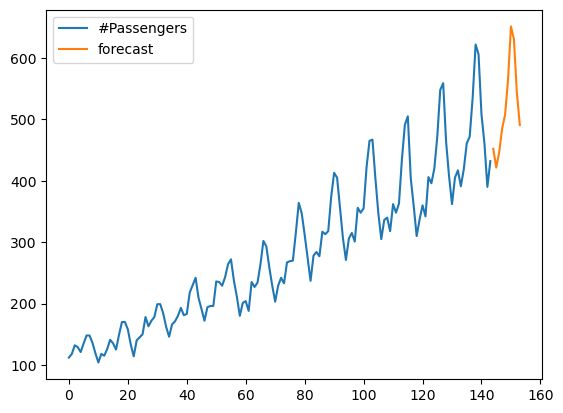

In [13]:
# Define the number of steps to forecast
forecast_steps = 10

# Forecast future values
forecast = model_fit.forecast(steps=forecast_steps)

# Create a range of future dates
date_range = pd.date_range(start=data['Month'].iloc[-1], periods=forecast_steps + 1, freq='MS')[1:]

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'Month': date_range, 'forecast': forecast})

# Merge the forecasted values with the original data
data = pd.concat([data, forecast_df], ignore_index=True)

data[['#Passengers','forecast']].plot()

> __Beautiful__, isnt it.

> The predicted values looks to follow the pattern.